In [1]:
#UNADJUSTED, ADJUSTED, AND ALL RATIOS MUST BE PLOTTED IN ORDER

import uproot
import awkward as ak
import numpy as np
import pandas as pd
import math
from mpmath import csc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
from IPython.display import Image, display
from IPython.display import HTML
import threading

np.seterr(divide='ignore', invalid='ignore') # Ignore division errors

# Use pandas to make an array of values ordered by event ID
features=['EventWeight', 'pt', 'phi', 'eta', 'probeCharge']
for i in range(4):
    features.append('dtDRbyStation_'+str(i))
    features.append('dtDPhibyStation_'+str(i))
    features.append('dtDEtabyStation_'+str(i))

class Type:
    def __init__(self, name, features):
        self.name = name
        self.sameSignFile = uproot.open('highHcal_'+str(name)+'_tagAligned (2).root')
        self.sameSignEvents = self.sameSignFile['demo']['allEvents']['sigVariables']
        self.branches = self.sameSignEvents.arrays()
        self.EventWeight = self.branches['EventWeight']
        self.eta = self.branches['eta']
        self.phi = self.branches['phi']

        self.Events = self.sameSignEvents.arrays(features, library='pd')
        
        
        self.DR_S = []
        self.DPhi_S = []
        self.DEta_S = []

        for i in range (4):
            self.DR_S.append(self.branches['dtDRbyStation_' + str(i)])
            self.DPhi_S.append(self.branches['dtDPhibyStation_' + str(i)])
            self.DEta_S.append(self.branches['dtDEtabyStation_' + str(i)])

        self.proximity_mask = []

Data = Type('data', features)
MC = Type('mc', features)

print('init uproot')

init uproot


In [2]:
#Data.sameSignFile.keys()
#Data.sameSignEvents
print(Data.sameSignEvents.keys())
print(np.mean(Data.branches['pt']))

['pt', 'eta', 'phi', 'staDR', 'staPhi', 'staE', 'standaloneDEoverE', 'staChi', 'cscDR', 'probeCharge', 'ecalIso', 'cellEdgeDeta', 'cellEdgeDphi', 'PUupWeight', 'PUdownWeight', 'IDupWeight', 'IDdownWeight', 'ISOupWeight', 'ISOdownWeight', 'TrigUpWeight', 'TrigDownWeight', 'EnBinWeight', 'lumi', 'event', 'cscDRbyStation_0', 'dtDRbyStation_0', 'cscDEtabyStation_0', 'dtDEtabyStation_0', 'cscDPhibyStation_0', 'dtDPhibyStation_0', 'cscDZbyStation_0', 'dtDZbyStation_0', 'cscDRbyStation_1', 'dtDRbyStation_1', 'cscDEtabyStation_1', 'dtDEtabyStation_1', 'cscDPhibyStation_1', 'dtDPhibyStation_1', 'cscDZbyStation_1', 'dtDZbyStation_1', 'cscDRbyStation_2', 'dtDRbyStation_2', 'cscDEtabyStation_2', 'dtDEtabyStation_2', 'cscDPhibyStation_2', 'dtDPhibyStation_2', 'cscDZbyStation_2', 'dtDZbyStation_2', 'cscDRbyStation_3', 'dtDRbyStation_3', 'cscDEtabyStation_3', 'dtDEtabyStation_3', 'cscDPhibyStation_3', 'dtDPhibyStation_3', 'cscDZbyStation_3', 'dtDZbyStation_3', 'HEDepth_0', 'found_HEDepth_0', 'HEDepth

In [3]:
#Coord refers to DR, DPhi, or DEta
class Coord:
    def __init__(self,name,x1,x2,bins):
        self.name = name
        self.x1 = x1
        self.x2 = x2
        self.bins = np.linspace(x1, x2, bins+1)  # creates an array of bin edges
        self.bin_width = (x2 - x1) / bins

DR = Coord('DR',-1,0.3,300)     # set delta coord edges/bin
DPhi = Coord('DPhi',-3,3,200)   # set delta coord edges/bin
DEta = Coord('DEta',-3,3,500)   # set delta coord edges/bin

mc_eta_mask = abs(MC.Events['eta']) <= 0.85
data_eta_mask = abs(Data.Events['eta']) <= 0.85

MC.Events = MC.Events.loc[mc_eta_mask]
Data.Events = Data.Events.loc[data_eta_mask]

mc_pos_charge_mask = MC.Events['probeCharge'] > 0
mc_neg_charge_mask = MC.Events['probeCharge'] < 0
data_pos_charge_mask = Data.Events['probeCharge'] > 0
data_neg_charge_mask = Data.Events['probeCharge'] < 0

# Re-bin all points above 0.3 to -1
for i in range(4):
    MC.Events['dtDRbyStation_'+str(i)] = MC.Events['dtDRbyStation_'+str(i)].apply(lambda x: -1 if x > DR.x2 else x)
    Data.Events['dtDRbyStation_'+str(i)] = Data.Events['dtDRbyStation_'+str(i)].apply(lambda x: -1 if x > DR.x2 else x)
    MC.DR_S[i] = ak.Array(MC.Events['dtDRbyStation_'+str(i)])
    Data.DR_S[i] = ak.Array(Data.Events['dtDRbyStation_'+str(i)])
    
    MC.Events['dtDPhibyStation_'+str(i)] = MC.Events['dtDPhibyStation_'+str(i)].apply(lambda x: -1 if abs(x) > DPhi.x2 else x) 
    Data.Events['dtDPhibyStation_'+str(i)] = Data.Events['dtDPhibyStation_'+str(i)].apply(lambda x: -1 if abs(x) > DPhi.x2 else x) 
    MC.DPhi_S[i] = ak.Array(MC.Events['dtDPhibyStation_'+str(i)])
    Data.DPhi_S[i] = ak.Array(Data.Events['dtDPhibyStation_'+str(i)])
    
    MC.Events['dtDEtabyStation_'+str(i)] = MC.Events['dtDEtabyStation_'+str(i)].apply(lambda x: -1 if abs(x) > DEta.x2 else x) 
    Data.Events['dtEtabyStation_'+str(i)] = Data.Events['dtDEtabyStation_'+str(i)].apply(lambda x: -1 if abs(x) > DEta.x2 else x) 
    MC.DEta_S[i] = ak.Array(MC.Events['dtDEtabyStation_'+str(i)]) 
    Data.DEta_S[i] = ak.Array(Data.Events['dtDEtabyStation_'+str(i)])

print('Re-Binned points')

#---------------------------------------------------------------------------------------------------------------------------------------

Coordinates = [DR, DPhi, DEta]
for i in range(4):
    for coord in Coordinates:
        bin_indices = np.zeros_like(MC.DR_S[i].to_numpy())                      # Array for storing bin indices
        for j, deltaCoord in enumerate(MC.DR_S[i]):                             # [(0, delta_R), (1, delta_R) ...] <--- list(enumerate(")) should give this
            bin_indices[j] = np.digitize(deltaCoord, coord.bins) - 1            # returns bin index for each delta coord
            MC.Events[str(coord.name)+'_Bin_Station_'+str(i)] = bin_indices      # Add new column with bin indices
        print('MC init '+str(coord.name)+'_Bin_Station_'+str(i))
        
def init_data(i):
    for coord in Coordinates:
        bin_indices = np.zeros_like(Data.DR_S[i].to_numpy())                      # Array for storing bin indices
        for j, deltaCoord in enumerate(Data.DR_S[i]):                             # [(0, delta_R), (1, delta_R) ...] <--- list(enumerate(")) should give this
            bin_indices[j] = np.digitize(deltaCoord, coord.bins) - 1            # returns bin index for each delta coord
            Data.Events[str(coord.name)+'_Bin_Station_'+str(i)] = bin_indices      # Add new column with bin indices      
        print('Data init '+str(coord.name)+'_Bin_Station_'+str(i))
    #print(mcEvents[:5])
    
t = []
if __name__ =="__main__": 
    for i in range(4):
        t.append(threading.Thread(target=init_data, args=(i,)))
    for i in range(4):
        t[i].start()
    for i in range(4):
        t[i].join()

print('init dataframe')

# Initialize class to help calculate normalized histograms for any data set
class NormalizedHist:
    def __init__(self, data, view_bins, bin_width):
        self.data = data[0]
        self.view_bins = view_bins
        self.bin_width = bin_width
        self.norm_factor = 1 / (np.sum(self.data) * self.bin_width)              # normalization factor
        self.temp = (data[1] + self.bin_width / 2)                               # offset bin edge values by + 1/2 bin
        self.bin_centers = self.temp[:-1]                                        # cut last value to give bin center
        self.freq = self.data * self.norm_factor                                 # normalized frequency
        self.err = (self.data ** 0.5) * self.norm_factor                         # normalized vertical error bar

print('init classes')

Re-Binned points
MC init DR_Bin_Station_0
MC init DPhi_Bin_Station_0
MC init DEta_Bin_Station_0
MC init DR_Bin_Station_1
MC init DPhi_Bin_Station_1
MC init DEta_Bin_Station_1
MC init DR_Bin_Station_2
MC init DPhi_Bin_Station_2
MC init DEta_Bin_Station_2
MC init DR_Bin_Station_3
MC init DPhi_Bin_Station_3
MC init DEta_Bin_Station_3
Data init DR_Bin_Station_2
Data init DR_Bin_Station_3
Data init DR_Bin_Station_0
Data init DR_Bin_Station_1
Data init DPhi_Bin_Station_2
Data init DPhi_Bin_Station_3
Data init DPhi_Bin_Station_0
Data init DPhi_Bin_Station_1
Data init DEta_Bin_Station_3
Data init DEta_Bin_Station_2
Data init DEta_Bin_Station_0
Data init DEta_Bin_Station_1
init dataframe
init classes


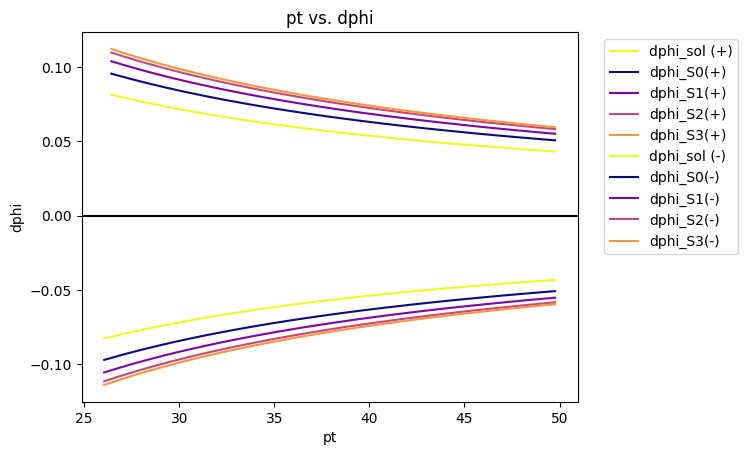

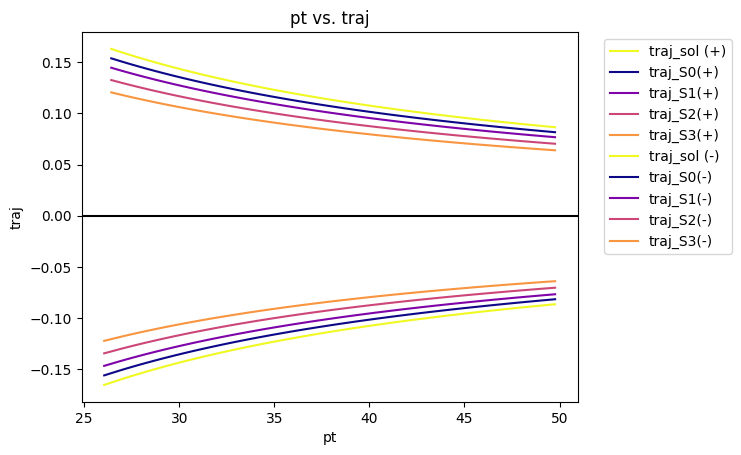

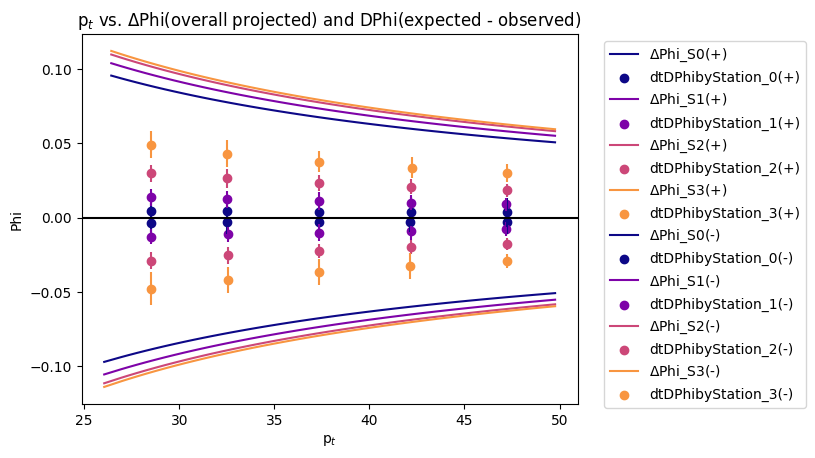

In [5]:
# Calculate projected motion of muon as calculated dphi and trajectory as it passes each station

columns = ['charge', 'pt', 'dphi_sol']
for j in range(4): columns.append('dphi_S'+str(j))
columns.append('traj_sol')
for j in range(4): columns.append('traj_S'+str(j))

projData = pd.DataFrame(columns=columns)
proj_event= {column: None for column in projData.columns} # make dictionary to add event attributes


R_S = []
R_sol = (3.55)  # radius of solenoid
R_S.append(4.35)  # radius of station 0
R_S.append(5.15)
R_S.append(6.20)
R_S.append(7.25)

m = 0.1057
B0 = 4
B1 = -1


Charges = ['+','-']
for charge in Charges:
    if charge == '+':
        q = 1
        dataEvents = Data.Events.loc[data_pos_charge_mask].copy()
        #mcEvents = MC.Events.loc[mc_pos_charge_mask].copy()
    elif charge == '-':
        q = -1
        dataEvents = Data.Events.loc[data_neg_charge_mask].copy()
        #mcEvents = MC.Events.loc[mc_neg_charge_mask].copy()
    
    for i in range(100): 
        pt_mask = (0.5*i <= dataEvents['pt']) & (dataEvents['pt'] <=  0.5*(i+1))
        pt_df = dataEvents.loc[pt_mask, ['pt']]
        pt = pt_df['pt'].mean()
        
        if pd.notnull(pt):
    
            R0 = 3.3*pt/(q*B0) # gyroradius
            R1 = 3.3*pt/(q*B1)
            
            R_stuff = (R0-R1)*R_sol**2/R0 # this factor pops up in mathematica simplification a lot
            D1 = math.sqrt(R1**2+R_stuff)
        
            dphi_sol = math.asin(R_sol/(2*R0))    # dphi as muon passes solenoid
            traj_sol = 2*dphi_sol                 # trajectory as muon passes solenoid
            x = (R0-R1)*math.sin(2*dphi_sol)      # x-coordinate of center of R1 circle
            y = R0+(R1-R0)*math.cos(2*dphi_sol)   # y-coordinate of center of R1 circle

            proj_event['pt'] = pt
            proj_event['charge'] = charge
            proj_event['dphi_sol'] = dphi_sol
            proj_event['traj_sol'] = traj_sol
        
            for j in range(4):
                dphi = ( q*math.acos( (R_stuff + R_S[j]**2) / (2*D1*R_S[j]) ) +
                           math.atan( 1/(R0-R1)*(R0+(R1-R0)*math.cos(2*dphi_sol))*csc(2*dphi_sol) ))
                traj =  math.atan( (R_S[j]*math.sin(dphi)-y) / (R_S[j]*math.cos(dphi)-x) ) + q*math.pi/2
                
                #print('projected dphi for Station_'+str(j)+' ('+charge+') charge bin '+str(i)+' pt_mean='+str(pt)+': '+str(dphi))
                
                proj_event['dphi_S'+str(j)] = dphi
                proj_event['traj_S'+str(j)] = traj
            projData.loc[len(projData)] = proj_event

#print(projData)

pos_mask = projData['charge'] == '+'
neg_mask = projData['charge'] == '-'

cmap = plt.get_cmap('plasma', 5)  # no. of colors = 5

Attributes = ['dphi','traj']
for attr in Attributes:
    for charge in Charges:
        if charge == '+': proj_mask = pos_mask 
        elif charge == '-': proj_mask = neg_mask
        plt.plot(projData.loc[proj_mask,'pt'], projData.loc[proj_mask,attr+'_sol'], color=cmap(4), label=attr+'_sol ('+charge+')')
        for j in range(4): 
            plt.plot(projData.loc[proj_mask,'pt'],projData.loc[proj_mask,attr+'_S'+str(j)], color=cmap(j), label=attr+'_S'+str(j)+'('+charge+')')

    plt.axhline(y=0, color='k')
    plt.xlabel('pt')
    plt.ylabel(attr)
    plt.title('pt vs. '+attr)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")    
    plt.show()

bins = 10

for charge in Charges:
    if charge == '+': 
        proj_mask = pos_mask 
        dataEvents = Data.Events.loc[data_pos_charge_mask].copy()
    elif charge == '-': 
        proj_mask = neg_mask
        dataEvents = Data.Events.loc[data_neg_charge_mask].copy()
    for j in range(4):
        phi_peak_mask = (-0.1<=dataEvents['dtDPhibyStation_'+str(j)])&(dataEvents['dtDPhibyStation_'+str(j)] <= 0.1) 
        dataEvents = dataEvents.loc[phi_peak_mask]
        dataEvents = dataEvents[dataEvents['dtDPhibyStation_'+str(j)] != -1]
        real_dphi_mean = []
        real_dphi_std = []
        pt =[]
        for i in range(bins): 
            pt_mask = (50*i/bins <= dataEvents['pt']) & (dataEvents['pt'] <=  50*(i+1)/bins)
            pt_df = dataEvents.loc[pt_mask, ['pt']]
            pt.append(pt_df['pt'].mean())
            real_dphi_df = dataEvents.loc[pt_mask, ['dtDPhibyStation_'+str(j)]]
            real_dphi_mean.append(real_dphi_df['dtDPhibyStation_'+str(j)].mean())
            real_dphi_std.append(real_dphi_df['dtDPhibyStation_'+str(j)].std())
            
        plt.plot(projData.loc[proj_mask,'pt'],projData.loc[proj_mask,'dphi_S'+str(j)], color=cmap(j), label='$\Delta$Phi_S'+str(j)+'('+charge+')')
        plt.scatter(pt, real_dphi_mean, color=cmap(j), label='dtDPhibyStation_'+str(j)+'('+charge+')')
        plt.errorbar(pt, real_dphi_mean, color=cmap(j), yerr=real_dphi_std, ls='none')

plt.axhline(y=0, color='k')
plt.xlabel('p$_t$')
plt.ylabel('Phi')
plt.title('p$_t$ vs. $\Delta$Phi(overall projected) and DPhi(expected - observed)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

In [6]:
# Method for plotting histograms
def generate_hist(condition, coord, charge, x1, x2, i, j, data):

    charge_ = '' 
    charge_ = '(+) ' if charge == '+' else charge_
    charge_ = '(-) ' if charge == '-' else charge_

    if i == 0 and condition == 'unadjusted':
        ratio_Station, ratio_Iter = data
        if charge == '':
            dataEvents = Data.Events.copy()
            mcEvents = MC.Events.copy()
        elif charge == '+':
            dataEvents = Data.Events.loc[data_pos_charge_mask].copy()
            mcEvents = MC.Events.loc[mc_pos_charge_mask].copy()
        elif charge == '-':
            dataEvents = Data.Events.loc[data_neg_charge_mask].copy()
            mcEvents = MC.Events.loc[mc_neg_charge_mask].copy()
    else:
        ratio_Station, ratio_Iter, dataEvents, mcEvents = data

    Data.DR_S[i] = ak.Array(dataEvents['dtDRbyStation_'+str(i)])
    MC.DR_S[i] = ak.Array(mcEvents['dtDRbyStation_'+str(i)])
    Data.DPhi_S[i] = ak.Array(dataEvents['dtDPhibyStation_'+str(i)])
    MC.DPhi_S[i] = ak.Array(mcEvents['dtDPhibyStation_'+str(i)])
    Data.DEta_S[i] = ak.Array(dataEvents['dtDEtabyStation_'+str(i)])
    MC.DEta_S[i] = ak.Array(mcEvents['dtDEtabyStation_'+str(i)]) 
    MC.EventWeight = ak.Array(mcEvents['EventWeight'])
    
    if coord.name == 'DR':
        station_Data = Data.DR_S[i]
        station_MC = MC.DR_S[i]
    elif coord.name == 'DPhi':
        if charge == '':
            station_Data = np.abs(Data.DPhi_S[i])
            station_MC = np.abs(MC.DPhi_S[i])
        else:
            station_Data = Data.DPhi_S[i]
            station_MC = MC.DPhi_S[i]
    elif coord.name == 'DEta':
        if charge == '':
            station_Data = np.abs(Data.DEta_S[i])
            station_MC = np.abs(MC.DEta_S[i]) 
        else: 
            station_Data = Data.DEta_S[i]
            station_MC = MC.DEta_S[i] 

    if condition == 'unadjusted':
        weights = MC.EventWeight
    elif condition == 'adjusted':
        weights = MC.EventWeight*mcEvents['Ratio_Station_'+str(j)].to_list()
    elif condition == 'all ratios':
        if i == 0:
            mcEvents['All_Ratios'] = mcEvents['Ratio_Station_0']*mcEvents['Ratio_Station_1']*mcEvents['Ratio_Station_2']*mcEvents['Ratio_Station_3'] # by event
        weights = MC.EventWeight*mcEvents['All_Ratios'].to_list()
    elif condition == 'iterative':
        if j == 0 and i == 0:
            mcEvents['Ratio_Iter_0'] = mcEvents['Ratio_Station_0'].to_list()
        weights = MC.EventWeight
        for k in range(j+1):
            weights = weights*mcEvents['Ratio_Iter_'+str(k)].to_list()

    # Create numpy histogram data for Data & MC so ratio can be calculated by initializing each as NormalizedHist Class
    data_hist = NormalizedHist(np.histogram(station_Data, bins=coord.bins, range=(coord.x1, coord.x2), density=None), len(coord.bins), coord.bin_width)
    mc_hist = NormalizedHist(np.histogram(station_MC, bins=coord.bins, range=(coord.x1, coord.x2), density=None, weights=weights), len(coord.bins), coord.bin_width)
        
    if condition == 'adjusted' or condition == 'all ratios':
        mc_hist_unadj = NormalizedHist(np.histogram(station_MC, bins=coord.bins, range=(coord.x1, coord.x2), density=None, weights=MC.EventWeight), len(coord.bins), coord.bin_width)
        adj_factor = np.divide(mc_hist.freq, mc_hist_unadj.freq + 1e-10)
    elif condition == 'iterative':
        if j == 0:
            mc_hist_unadj = NormalizedHist(np.histogram(station_MC, bins=coord.bins, range=(coord.x1, coord.x2), density=None, weights=MC.EventWeight), len(coord.bins), coord.bin_width)
        else:
            mc_hist_unadj = NormalizedHist(np.histogram(station_MC, bins=coord.bins, range=(coord.x1, coord.x2), density=None, weights=MC.EventWeight*mcEvents['Ratio_Iter_'+str(j-1)].to_list()), len(coord.bins), coord.bin_width)
        adj_factor = np.divide(mc_hist.freq, mc_hist_unadj.freq + 1e-10)
    
    ratio_freq = np.divide(data_hist.freq, mc_hist.freq)
    ratio_freq = [1 if (math.isinf(x) or math.isnan(x)) else x for x in ratio_freq] # goodify the infinities
    ratio_err = ratio_freq * np.sqrt((data_hist.err / (data_hist.freq + 1e-10))**2 + (mc_hist.err / (mc_hist.freq + 1e-10))**2) 
    
    # calculate ratio error -> propagation of uncertainty

    if condition == 'unadjusted':
        # Loop over events, assign bin ratio to each event
        ratio_Station.append(np.zeros_like(station_MC.to_numpy()))             # create empty array similar to DCoord for station[j]
        for k, deltaCoord in enumerate(station_MC.to_numpy()):                 # [(0, delta_R), (1, delta_R) ...] <--- list(enumerate(")) should give this
            bin_index = np.digitize(deltaCoord, coord.bins) - 1                # returns bin index for each delta coord
            if bin_index >= len(ratio_freq):                                   # check if index is out of bound
                bin_index = len(ratio_freq) - 1                                # assign the last valid index
            ratio_Station[i][k] = ratio_freq[bin_index]                        # find item k in array and change it to the ratio_freq of that bin index    
        assert len(station_MC) == len(ratio_Station[i])            # make sure length matches
        mcEvents['Ratio_Station_'+str(i)] = ratio_Station[i]       # add new column
        ######### print(mcEvents['Ratio_Station_'+str(i)])

    if condition == 'iterative' and i-1 == j:                                  # take ratio freq between Station_i Data and MC adjusted by ratio from station (i-1) adjusted MC for 
        ratio_iter = ratio_freq                                                # recall that ratio_freq has already been iterated in this case
        # Loop over events, assign bin ratio to each event
        ratio_Iter.append(np.zeros_like(station_MC.to_numpy()))                # create empty array similar to DCoord for station[j]
        for k, deltaCoord in enumerate(station_MC.to_numpy()):                 # [(0, delta_R), (1, delta_R) ...] <--- list(enumerate(")) should give this
            bin_index = np.digitize(deltaCoord, coord.bins) - 1                # returns bin index for each delta coord
            if bin_index >= len(ratio_iter):                                   # check if index is out of bound
                bin_index = len(ratio_iter) - 1                                # assign the last valid index
            ratio_Iter[j][k] = ratio_iter[bin_index]                           # find item k in array and change it to the ratio_iter of that bin index
    
        assert len(station_MC) == len(ratio_Iter[j])            # make sure length matches
        mcEvents['Ratio_Iter_'+str(i)] = ratio_Iter[j]          # add new column


    #PLOT -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -

    # Adjusting axs[0].step from bin edge to bin center results in loss of first bar because it is shifted 1/2 bin width; this adds that point back at 0
    step_bc = mc_hist.bin_centers+coord.bin_width/2
    step_f = mc_hist.freq
    step_bc.to_numpy
    step_f.to_numpy
    step_bin_centers = np.insert(step_bc, 0, 0.0)
    step_freq = np.insert(step_f, 0, mc_hist.freq[0])

    # Set up histogram
    fig = plt.figure(figsize=(7,5))
    gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[1, 19])

    # Plot data as points, use bars for MC
    ax0 = plt.subplot(gs[0, 1])
    if condition == 'unadjusted':
        ax0.set_title(charge_+'Distance to Station '+str(i))
    elif condition == 'adjusted':
        ax0.set_title(charge_+'Distance to Station '+str(i)+' Weighted by Station '+str(j)+' Ratios')
    elif condition == 'all ratios':
        ax0.set_title(charge_+'Distance to Station '+str(i)+' Weighted by All Ratios')
    elif condition == 'iterative':
        ax0.set_title(charge_+'Distance to Station '+str(i)+' Weighted by Iterative Ratios '+str(j))
    ax0.set_yscale("log")
    ax0.set_xlim(x1, x2)
    ax0.step(step_bin_centers, step_freq, label='Monte Carlo')
    ax0.scatter(data_hist.bin_centers, data_hist.freq, s=10, color='darkorange', label='Data')
    ax0.errorbar(data_hist.bin_centers, data_hist.freq, xerr=coord.bin_width/2, yerr=mc_hist.err, fmt='+')
    if x2-x1 <= 0.35: ax0.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
    plt.setp(ax0.get_xticklabels(), visible=False) # remove x ticks from top right
    plt.setp(ax0.get_yticklabels(), visible=False) # remove y ticks from top right
    ax0.legend()
    # Show mean and std for MC
    if charge == '' and (coord.name == 'DEta' or coord.name == 'DPhi') :
        textstr = '\n'.join((
        r'$\mathrm{MC \ mean}=%.4f$' % (np.mean(station_MC[station_MC != 1]), ),
        r'$\mathrm{MC \ }\sigma=%.4f$' % (np.std(station_MC[station_MC != 1]), )))
    else:
        textstr = '\n'.join((
        r'$\mathrm{MC \ mean}=%.4f$' % (np.mean(station_MC[station_MC != -1]), ),
        r'$\mathrm{MC \ }\sigma=%.4f$' % (np.std(station_MC[station_MC != -1]), )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax0.text(0.98, 0.78, textstr, transform=ax0.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props) 
    
    # Scatter ratio plot
    ax1 = plt.subplot(gs[1, 1], sharex = ax0)
    ax1.scatter(data_hist.bin_centers, ratio_freq, s=10)
    ax1.errorbar(data_hist.bin_centers, ratio_freq, yerr=ratio_err, fmt='+')
    ax1.set_ylim(0,2)
    ax1.set_xlabel('$\Delta$'+coord.name[1:]+' to Station '+str(i))
    if x2-x1 <= 0.35: plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
    plt.setp(ax1.get_yticklabels(), visible=False) # remove y ticks from bottom right

    # Plot underflow bins    
    ax2 = plt.subplot(gs[0, 0], sharey=ax0)
    ax2.step(step_bin_centers-coord.bin_width, step_freq, label='Monte Carlo')
    ax2.scatter(data_hist.bin_centers, data_hist.freq, s=10, color='darkorange', label='Data')
    ax2.errorbar(data_hist.bin_centers, data_hist.freq, xerr=coord.bin_width/2, yerr=mc_hist.err, fmt='+')
    ax2.set_xlim(-1, -1+coord.bin_width)
    ax2.set_ylabel('Event Frequency (Normalized)')
    plt.setp(ax2.get_xticklabels(), visible=False) # remove x ticks from top left

    # Plot underflow ratio
    ax3 = plt.subplot(gs[1, 0], sharey=ax1, sharex=ax2)
    ax3.scatter(data_hist.bin_centers, ratio_freq, s=10)
    ax3.errorbar(data_hist.bin_centers, ratio_freq, yerr=ratio_err, fmt='+')
    ax3.set_ylim(0,2)
    ax3.set_ylabel('Ratio')
    # Show only the first tick label for the bottom left subplot as integer
    xticks = ax3.xaxis.get_major_ticks()
    plt.setp(ax3.get_xticklabels(), visible=False)
    xticks[0].label1.set_visible(True)
    ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax3.tick_params(axis='x', length=0)

    # Remove vertical gap between subplots
    plt.subplots_adjust(wspace=0.0, hspace=0.0)

    # Save plots as .jpg
    if condition == 'unadjusted':
        plt.savefig(charge_+coord.name+' Distance to Station '+str(i)+'.jpg')
    elif condition == 'adjusted':
        plt.savefig(charge_+coord.name+' Distance to Station '+str(i)+' Weighted by Station '+str(j)+' Ratios.jpg')
    elif condition == 'all ratios':
        plt.savefig(charge_+coord.name+' Distance to Station '+str(i)+' Weighted by All Ratios.jpg')
    elif condition == 'iterative':
        plt.savefig(charge_+coord.name+' Distance to Station '+str(i)+' Weighted by Iterative Ratios '+str(j)+'.jpg')
    plt.close() # prevents figure from being displayed when code cell is executed

    # Plot ratios
    if condition != 'unadjusted':
        fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={'wspace': 0, 'width_ratios': [1, 19]}, figsize=(7, 5))
        axs[0].scatter(data_hist.bin_centers, adj_factor)
        axs[0].set_xlim(-1,-1+coord.bin_width)
        axs[1].scatter(data_hist.bin_centers, adj_factor)
        axs[1].set_xlim(0,x2)
        plt.xlabel('$\Delta$'+coord.name[1:]+' to Station '+str(j))
        axs[0].set_ylabel('Adjustment Factor')
        # Show only the first tick label for the left subplot as integer
        xticks = axs[0].xaxis.get_major_ticks()
        plt.setp(axs[0].get_xticklabels(), visible=False)
        xticks[0].label1.set_visible(True)
        axs[0].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        axs[0].tick_params(axis='x', length=0)
        if condition == 'adjusted':
            plt.title(charge_+'Net Adjustment by Station '+str(j)+' Ratios for Station '+str(i))
            plt.savefig(charge_+coord.name+' Net Adjustment by Station '+str(j)+' Ratios for Station '+str(i)+'.jpg')
        elif condition == 'all ratios':
            plt.title(charge_+'Net Adjustment by All Ratios for Station '+str(i))
            plt.savefig(charge_+coord.name+' Net Adjustment by All Ratios for Station '+str(i)+'.jpg')
        elif condition == 'iterative':
            plt.title(charge_+'Net Adjustment by Iterative Ratios '+str(j)+' for Station '+str(i))
            plt.savefig(charge_+coord.name+' Net Adjustment by Iterative Ratios '+str(j)+' for Station '+str(i)+'.jpg')
        plt.close()
    return ratio_Station, ratio_Iter, dataEvents, mcEvents

print('init generate_hist')
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    
def compile_hist(coord, charge, x1, x2):
    ratio_Station = []
    ratio_Iter = []
    data = ratio_Station, ratio_Iter
    for i in range (4):
        data = generate_hist(condition='unadjusted', coord=coord, charge=charge, x1=x1, x2=x2, i=i, j=0, data=data)
    print('compiled unadjusted')

    for j in range (4):                          #j iterates through station weights
        for i in range (4):                      #i iterates through stations
            data = generate_hist(condition='adjusted', coord=coord, charge=charge, x1=x1, x2=x2, i=i, j=j, data=data)
    print('compiled adjusted')

    for i in range (4):                    
        data = generate_hist(condition='all ratios', coord=coord, charge=charge, x1=x1, x2=x2, i=i, j=0, data=data)
    print('compiled all ratios')

    for j in range (4):                          
        for i in range (4):                      
            data = generate_hist(condition='iterative', coord=coord, charge=charge, x1=x1, x2=x2, i=i, j=j, data=data)
    print('compiled iterative')

    return data
        
print('init compile_hist')

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

def plot_hist(coord, charge):

    charge_ = '' 
    charge_ = '(+) ' if charge == '+' else charge_
    charge_ = '(-) ' if charge == '-' else charge_

    for j in range(4):
        for k in range(2):
            print("\n") 
        print('                            ------------------------------------------------------------------------------- All Stations Weighted by Station '+str(j)+' Ratios: -------------------------------------------------------------------------------')
        for k in range(2):
            print("\n")
        for i in range(4):
            display(HTML("<table><tr><td><img src='"+charge_+""+coord.name+" Distance to Station "+str(i)+".jpg'></td><td><img src='"+charge_+""+coord.name+" Net Adjustment by Station "+str(j)+" Ratios for Station "+str(i)+".jpg'></td><td><img src='"+charge_+""+coord.name+" Distance to Station "+str(i)+" Weighted by Station "+str(j)+" Ratios.jpg'></td></tr></table>"))
    
    for k in range(2):
        print("\n") 
    print('                            ------------------------------------------------------------------------------- All Stations Weighted by All Ratios: -------------------------------------------------------------------------------')
    for k in range(2):
        print("\n")
    for i in range(4):
        display(HTML("<table><tr><td><img src='"+charge_+""+coord.name+" Distance to Station "+str(i)+".jpg'></td><td><img src='"+charge_+""+coord.name+" Net Adjustment by All Ratios for Station "+str(i)+".jpg'></td><td><img src='"+charge_+""+coord.name+" Distance to Station "+str(i)+" Weighted by All Ratios.jpg'></td></tr></table>"))

    for j in range(4):
        for k in range(2):
            print("\n") 
        print('                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios '+str(j)+': -------------------------------------------------------------------------------')
        for k in range(2):
            print("\n")
        for i in range(4):
            display(HTML("<table><tr><td><img src='"+charge_+""+coord.name+" Distance to Station "+str(i)+".jpg'></td><td><img src='"+charge_+""+coord.name+" Net Adjustment by Iterative Ratios "+str(j)+" for Station "+str(i)+".jpg'></td><td><img src='"+charge_+""+coord.name+" Distance to Station "+str(i)+" Weighted by Iterative Ratios "+str(j)+".jpg'></td></tr></table>"))

print('init plot_hist')

print('initialized')

def plot_charge_hist(coord):
    for i in range(4):
            display(HTML("<table><tr><td><img src='(+) "+coord.name+" Distance to Station "+str(i)+".jpg'></td><td><img src='(-) "+coord.name+" Distance to Station "+str(i)+".jpg'></td></tr></table>"))

init generate_hist
init compile_hist
init plot_hist
initialized


In [7]:
compile_hist(DR, '', 0, DR.x2)
plot_hist(DR, '')

compiled unadjusted
compiled adjusted
compiled all ratios
compiled iterative




                            ------------------------------------------------------------------------------- All Stations Weighted by Station 0 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Station 1 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Station 2 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Station 3 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by All Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 0: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 1: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 2: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 3: -------------------------------------------------------------------------------






,,


,,


,,


,,


In [8]:
compile_hist(DPhi, '', 0 , 0.35)
plot_hist(DPhi, '')

compiled unadjusted
compiled adjusted
compiled all ratios
compiled iterative




                            ------------------------------------------------------------------------------- All Stations Weighted by Station 0 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Station 1 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Station 2 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Station 3 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by All Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 0: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 1: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 2: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 3: -------------------------------------------------------------------------------






,,


,,


,,


,,


In [9]:
compile_hist(DEta, '', 0, 0.35)
plot_hist(DEta, '')

compiled unadjusted
compiled adjusted
compiled all ratios
compiled iterative




                            ------------------------------------------------------------------------------- All Stations Weighted by Station 0 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Station 1 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Station 2 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Station 3 Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by All Ratios: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 0: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 1: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 2: -------------------------------------------------------------------------------






,,


,,


,,


,,






                            ------------------------------------------------------------------------------- All Stations Weighted by Iterative Ratios 3: -------------------------------------------------------------------------------






,,


,,


,,


,,


In [10]:
compile_hist(DPhi, '+', -0.35, 0.35)
compile_hist(DPhi, '-', -0.35, 0.35)
plot_charge_hist(DPhi)

compiled unadjusted
compiled adjusted
compiled all ratios
compiled iterative
compiled unadjusted
compiled adjusted
compiled all ratios
compiled iterative


,


,


,


,


In [11]:
ratio_Station, ratio_Iter, dataEvents, mcEvents = compile_hist(DEta, '', 0, 1.5)

Types = [Data, MC]

for i in range(4):
    bad_bins_filter = [value >= 0 for value in mcEvents['Ratio_Station_'+str(i)].to_list()]
    bad_bins = [k for k, x in enumerate(bad_bins_filter) if x]
    mc_bad_events = mcEvents[mcEvents['DEta_Bin_Station_'+str(i)].isin(bad_bins)]
    data_bad_events = dataEvents[dataEvents['DEta_Bin_Station_'+str(i)].isin(bad_bins)]

for type in Types:
    Muon_Eta = []
    Muon_Phi = []
    Event_Weight = []
    
    if type == Data:
        EventWeight = data_bad_events['EventWeight']
        Muon_eta = data_bad_events['eta']
        Muon_phi = data_bad_events['phi']
    if type == MC:
        EventWeight = mc_bad_events['EventWeight']
        Muon_eta = mc_bad_events['eta']
        Muon_phi = mc_bad_events['phi']

    for i in range (4):
        Muon_Eta.append([float(value) for value in Muon_eta]) 
        Muon_Phi.append([float(value) for value in Muon_phi]) 
        Event_Weight.append([float(value) for value in EventWeight])


    Total_Hits = np.histogram2d(Muon_eta, Muon_phi, bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=EventWeight)
    
    for i in range (4):
        xedges, yedges = Total_Hits[2], Total_Hits[1]
        fig = plt.figure(figsize=(30, 30), dpi=100)
        ax = fig.add_subplot(131, title=str(type.name)+' Station '+str(i)+' DT hits Overall, eta_mask ')
        plt.imshow(Total_Hits[0], interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        plt.xlabel('Muon $\phi$')
        plt.ylabel('Muon $\eta$')
        plt.colorbar(fraction=0.035, pad=0.04)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
        
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
        plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
        plt.savefig(str(type.name)+' Station '+str(i)+' Overall DT hits.jpg', bbox_inches='tight')
        plt.close()

for i in range(4):
    display(HTML("<table><tr><td><img src='data Station "+str(i)+" Overall DT hits.jpg'></td><td><img src='mc Station "+str(i)+" Overall DT hits.jpg'></td></tr></table>"))

compiled unadjusted
compiled adjusted
compiled all ratios
compiled iterative


,


,


,


,


In [12]:
peak_lim = 0.05

for coord in [DEta, DPhi]:

    ratio_Station, ratio_Iter, dataEvents, mcEvents = compile_hist(coord, '', 0, 1.5)
        
    Data.proximity_mask = []
    MC.proximity_mask = []
    for i in range(4):
        Data.proximity_mask.append(abs(dataEvents['dt'+coord.name+'byStation_'+str(i)]) <= peak_lim)
        MC.proximity_mask.append(abs(mcEvents['dt'+coord.name+'byStation_'+str(i)]) <= peak_lim)
    
        
    print('In peak MC events: ', np.sum(MC.proximity_mask[0]), np.sum(MC.proximity_mask[1]), np.sum(MC.proximity_mask[2]), np.sum(MC.proximity_mask[3]))
    print('Out of peak MC events: ', np.sum(~MC.proximity_mask[0]), np.sum(~MC.proximity_mask[1]), np.sum(~MC.proximity_mask[2]), np.sum(~MC.proximity_mask[3]))
    
    print('In peak Data events: ', np.sum(Data.proximity_mask[0]), np.sum(Data.proximity_mask[1]), np.sum(Data.proximity_mask[2]), np.sum(Data.proximity_mask[3]))
    print('Out of peak Data events: ', np.sum(~Data.proximity_mask[0]), np.sum(~Data.proximity_mask[1]), np.sum(~Data.proximity_mask[2]), np.sum(~Data.proximity_mask[3]))
    
    def fraction(prox_mask):
        return np.sum(prox_mask)/(np.sum(prox_mask)+np.sum(~prox_mask))
    
    print('Fraction In/Total MC events: ', fraction(MC.proximity_mask[0]), fraction(MC.proximity_mask[1]), fraction(MC.proximity_mask[2]), fraction(MC.proximity_mask[3]))
    print('Fraction In/Total Data events: ', fraction(Data.proximity_mask[0]), fraction(Data.proximity_mask[1]), fraction(Data.proximity_mask[2]), fraction(Data.proximity_mask[3]))
    
    
    Types = [Data, MC]
    
    for i in range(4):
        bad_bins_filter = [value >= 0 for value in mcEvents['Ratio_Station_'+str(i)].to_list()]
        bad_bins = [k for k, x in enumerate(bad_bins_filter) if x]
        mc_bad_events = mcEvents[mcEvents[coord.name+'_Bin_Station_'+str(i)].isin(bad_bins)]
        data_bad_events = dataEvents[dataEvents[coord.name+'_Bin_Station_'+str(i)].isin(bad_bins)]
    
    for type in Types:
        Muon_Eta = []
        Muon_Phi = []
        Event_Weight = []
        
        if type == Data:
            EventWeight = data_bad_events['EventWeight']
            Muon_eta = data_bad_events['eta']
            Muon_phi = data_bad_events['phi']
        if type == MC:
            EventWeight = mc_bad_events['EventWeight']
            Muon_eta = mc_bad_events['eta']
            Muon_phi = mc_bad_events['phi']
    
        for i in range (4):
            Muon_Eta.append([float(value) for value in Muon_eta[type.proximity_mask[i]]]) #Muon_eta is eta masked
            Muon_Phi.append([float(value) for value in Muon_phi[type.proximity_mask[i]]]) #Muon_phi is eta masked
            Event_Weight.append([float(value) for value in EventWeight[type.proximity_mask[i]]])
    
    
        Total_Hits = np.histogram2d(Muon_eta, Muon_phi, bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=EventWeight)
        Prox_Hits = []
        Eff_Hits = []
        
        for i in range (4):
            Prox_Hits.append(np.histogram2d(Muon_Eta[i], Muon_Phi[i], bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=Event_Weight[i]))
            Eff_Hits.append(np.divide(Prox_Hits[i][0],Total_Hits[0]))
            xedges, yedges = Prox_Hits[i][2], Prox_Hits[i][1]
            fig = plt.figure(figsize=(30, 30), dpi=100)
            ax = fig.add_subplot(131, title=str(type.name)+' Station '+str(i)+' DT hits, eta_mask + peak isolation '+coord.name+' <= '+str(peak_lim))
            plt.imshow(Eff_Hits[i], interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
            plt.xlabel('Muon $\phi$')
            plt.ylabel('Muon $\eta$')
            plt.colorbar(fraction=0.035, pad=0.04)
            ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
            
            plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
            plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
            plt.savefig(str(type.name)+' Station '+str(i)+' DT hits '+coord.name+' peak.jpg', bbox_inches='tight')
            plt.close()
    
    for i in range(4):
        display(HTML("<table><tr><td><img src='data Station "+str(i)+" DT hits "+coord.name+" peak.jpg'></td><td><img src='mc Station "+str(i)+" DT hits "+coord.name+" peak.jpg'></td></tr></table>"))


compiled unadjusted
compiled adjusted
compiled all ratios
compiled iterative
In peak MC events:  6587 7039 7206 2531
Out of peak MC events:  2122 1670 1503 6178
In peak Data events:  31436 33261 34215 12364
Out of peak Data events:  10166 8341 7387 29238
Fraction In/Total MC events:  0.7563440119416696 0.8082443449305317 0.8274199104374784 0.29061889998851764
Fraction In/Total Data events:  0.755636748233258 0.7995048314984856 0.8224364213258978 0.29719725013220516


,


,


,


,


compiled unadjusted
compiled adjusted
compiled all ratios
compiled iterative
In peak MC events:  7228 7554 7507 6551
Out of peak MC events:  1481 1155 1202 2158
In peak Data events:  34720 35867 35884 31958
Out of peak Data events:  6882 5735 5718 9644
Fraction In/Total MC events:  0.8299460328395912 0.8673785738890802 0.861981857848203 0.7522103571018487
Fraction In/Total Data events:  0.834575260804769 0.8621460506706409 0.8625546848709197 0.7681842219124081


,


,


,


,


In [13]:
over_lim = 1

for coord in [DEta, DPhi]:

    ratio_Station, ratio_Iter, dataEvents, mcEvents = compile_hist(coord, '', 0, 1.5)
        
    Data.proximity_mask = []
    MC.proximity_mask = []
    for i in range(4):
        Data.proximity_mask.append(abs(dataEvents['dt'+coord.name+'byStation_'+str(i)]) >= over_lim)
        MC.proximity_mask.append(abs(mcEvents['dt'+coord.name+'byStation_'+str(i)]) >= over_lim)
    
        
    print('Overflow MC events: ', np.sum(MC.proximity_mask[0]), np.sum(MC.proximity_mask[1]), np.sum(MC.proximity_mask[2]), np.sum(MC.proximity_mask[3]))
    print('In MC events: ', np.sum(~MC.proximity_mask[0]), np.sum(~MC.proximity_mask[1]), np.sum(~MC.proximity_mask[2]), np.sum(~MC.proximity_mask[3]))
    
    print('Overflow Data events: ', np.sum(Data.proximity_mask[0]), np.sum(Data.proximity_mask[1]), np.sum(Data.proximity_mask[2]), np.sum(Data.proximity_mask[3]))
    print('In Data events: ', np.sum(~Data.proximity_mask[0]), np.sum(~Data.proximity_mask[1]), np.sum(~Data.proximity_mask[2]), np.sum(~Data.proximity_mask[3]))
    
    def fraction(prox_mask):
        return np.sum(prox_mask)/(np.sum(prox_mask)+np.sum(~prox_mask))
    
    print('Fraction Overflow/Total MC events: ', fraction(MC.proximity_mask[0]), fraction(MC.proximity_mask[1]), fraction(MC.proximity_mask[2]), fraction(MC.proximity_mask[3]))
    print('Fraction Overflow/Total Data events: ', fraction(Data.proximity_mask[0]), fraction(Data.proximity_mask[1]), fraction(Data.proximity_mask[2]), fraction(Data.proximity_mask[3]))
    
    
    Types = [Data, MC]
    
    for i in range(4):
        bad_bins_filter = [value >= 0 for value in mcEvents['Ratio_Station_'+str(i)].to_list()]
        bad_bins = [k for k, x in enumerate(bad_bins_filter) if x]
        mc_bad_events = mcEvents[mcEvents[coord.name+'_Bin_Station_'+str(i)].isin(bad_bins)]
        data_bad_events = dataEvents[dataEvents[coord.name+'_Bin_Station_'+str(i)].isin(bad_bins)]
    
    for type in Types:
        Muon_Eta = []
        Muon_Phi = []
        Event_Weight = []
        
        if type == Data:
            EventWeight = data_bad_events['EventWeight']
            Muon_eta = data_bad_events['eta']
            Muon_phi = data_bad_events['phi']
        if type == MC:
            EventWeight = mc_bad_events['EventWeight']
            Muon_eta = mc_bad_events['eta']
            Muon_phi = mc_bad_events['phi']
    
        for i in range (4):
            Muon_Eta.append([float(value) for value in Muon_eta[type.proximity_mask[i]]]) #Muon_eta is eta masked
            Muon_Phi.append([float(value) for value in Muon_phi[type.proximity_mask[i]]]) #Muon_phi is eta masked
            Event_Weight.append([float(value) for value in EventWeight[type.proximity_mask[i]]])
    
    
        Total_Hits = np.histogram2d(Muon_eta, Muon_phi, bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=EventWeight)
        Prox_Hits = []
        Eff_Hits = []
        
        for i in range (4):
            Prox_Hits.append(np.histogram2d(Muon_Eta[i], Muon_Phi[i], bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=Event_Weight[i]))
            Eff_Hits.append(np.divide(Prox_Hits[i][0],Total_Hits[0]))
            xedges, yedges = Prox_Hits[i][2], Prox_Hits[i][1]
            fig = plt.figure(figsize=(30, 30), dpi=100)
            ax = fig.add_subplot(131, title=str(type.name)+' Station '+str(i)+' DT hits, eta_mask + overflow '+coord.name+' >= '+str(over_lim))
            plt.imshow(Eff_Hits[i], interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
            plt.xlabel('Muon $\phi$')
            plt.ylabel('Muon $\eta$')
            plt.colorbar(fraction=0.035, pad=0.04)
            ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
            
            plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
            plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
            plt.savefig(str(type.name)+' Station '+str(i)+' DT hits '+coord.name+' far.jpg', bbox_inches='tight')
            plt.close()
    
    for i in range(4):
        display(HTML("<table><tr><td><img src='data Station "+str(i)+" DT hits "+coord.name+" far.jpg'></td><td><img src='mc Station "+str(i)+" DT hits "+coord.name+" far.jpg'></td></tr></table>"))


compiled unadjusted
compiled adjusted
compiled all ratios
compiled iterative
Overflow MC events:  836 935 1112 1166
In MC events:  7873 7774 7597 7543
Overflow Data events:  3262 4400 5052 3640
In Data events:  38340 37202 36550 37962
Fraction Overflow/Total MC events:  0.09599265128028477 0.10736020208979218 0.1276840050522448 0.1338844873119761
Fraction Overflow/Total Data events:  0.07840969184173838 0.10576414595452142 0.12143646940050959 0.08749579347146771


,


,


,


,


compiled unadjusted
compiled adjusted
compiled all ratios
compiled iterative
Overflow MC events:  821 952 1122 1171
In MC events:  7888 7757 7587 7538
Overflow Data events:  3115 4472 5181 3969
In Data events:  38487 37130 36421 37633
Fraction Overflow/Total MC events:  0.09427029509702607 0.10931220576415203 0.1288322425077506 0.134458606039729
Fraction Overflow/Total Data events:  0.07487620787462142 0.10749483197923176 0.12453728186144897 0.09540406711215807


,


,


,


,


In [14]:
Data.proximity_mask = []
MC.proximity_mask = []

ranges = [[0.17,0.24],[0.155,0.22],[0.145,0.20]]

for i in range(3):
    Data.proximity_mask.append((ranges[i][0] <= abs(data_bad_events['dtDEtabyStation_0'])) & (abs(data_bad_events['dtDEtabyStation_0']) <= ranges[i][1]))
    MC.proximity_mask.append((ranges[i][0] <= abs(mc_bad_events['dtDEtabyStation_0'])) & (abs(mc_bad_events['dtDEtabyStation_0']) <= ranges[i][1]))

for type in Types:
    Muon_Eta = []
    Muon_Phi = []
    Event_Weight = []
    
    if type == Data:
        EventWeight = data_bad_events['EventWeight']
        Muon_eta = data_bad_events['eta']
        Muon_phi = data_bad_events['phi']
    if type == MC:
        EventWeight = mc_bad_events['EventWeight']
        Muon_eta = mc_bad_events['eta']
        Muon_phi = mc_bad_events['phi']

    for i in range (3):
        Muon_Eta.append([float(value) for value in Muon_eta[type.proximity_mask[i]]]) #Muon_eta is eta masked
        Muon_Phi.append([float(value) for value in Muon_phi[type.proximity_mask[i]]]) #Muon_phi is eta masked
        Event_Weight.append([float(value) for value in EventWeight[type.proximity_mask[i]]])

    Total_Hits = np.histogram2d(Muon_eta, Muon_phi, bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=EventWeight)
    Prox_Hits = []
    Eff_Hits = []
    
    for i in range (3):
        Prox_Hits.append(np.histogram2d(Muon_Eta[i], Muon_Phi[i], bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=Event_Weight[i]))
        Eff_Hits.append(np.divide(Prox_Hits[i][0],Total_Hits[0]))
        xedges, yedges = Prox_Hits[i][2], Prox_Hits[i][1]
        fig = plt.figure(figsize=(30, 30), dpi=100)
        ax = fig.add_subplot(131, title=str(type.name)+' Station '+str(i)+' DT hits, eta_mask + secondary peak isolation '+str(ranges[i][0])+' <= DEta >= '+str(ranges[i][1]))
        plt.imshow(Eff_Hits[i], interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        plt.xlabel('Muon $\phi$')
        plt.ylabel('Muon $\eta$')
        plt.colorbar(fraction=0.035, pad=0.04)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
        
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
        plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
        plt.savefig(str(type.name)+' Station '+str(i)+' DT hits by secondary peak.jpg', bbox_inches='tight')
        plt.close()

for i in range(3):
    display(HTML("<table><tr><td><img src='data Station "+str(i)+" DT hits by secondary peak.jpg'></td><td><img src='mc Station "+str(i)+" DT hits by secondary peak.jpg'></td></tr></table>"))


,


,


,


In [15]:
if 1 == 2:
    #Calculate the quantiles
    quantiles = [data_bad_events['dtDEtabyStation_0'].abs().quantile(i/10.0) for i in range(11)]
    
    for i in range(10):
        i1, i2 = quantiles[i], quantiles[i+1]
    
        Data.proximity_mask = (i1 <= abs(data_bad_events['dtDEtabyStation_0'])) & (abs(data_bad_events['dtDEtabyStation_0']) <= i2)
    
        EventWeight = data_bad_events['EventWeight']
        Muon_eta = data_bad_events['eta']
        Muon_phi = data_bad_events['phi']
    
        Muon_Eta = [float(value) for value in Muon_eta[Data.proximity_mask]] #Muon_eta is eta masked
        Muon_Phi = [float(value) for value in Muon_phi[Data.proximity_mask]] #Muon_phi is eta masked
        Event_Weight = [float(value) for value in EventWeight[Data.proximity_mask]]
    
        Total_Hits = np.histogram2d(Muon_eta, Muon_phi, bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=EventWeight)
    
        Prox_Hits = np.histogram2d(Muon_Eta, Muon_Phi, bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=Event_Weight)
        Eff_Hits = np.divide(Prox_Hits[0],Total_Hits[0])
        xedges, yedges = Prox_Hits[2], Prox_Hits[1]
        fig = plt.figure(figsize=(30, 30), dpi=100)
        ax = fig.add_subplot(131, title=str(type.name)+' Station 0 DT hits, eta_mask + secondary peak isolation '+str(i1)+' <= DEta >= '+str(i2))
        plt.imshow(Eff_Hits, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        plt.xlabel('Muon $\phi$')
        plt.ylabel('Muon $\eta$')
        plt.colorbar(fraction=0.035, pad=0.04)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    
        plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
        plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
        plt.plot()
else:
    print('skipped cell')


skipped cell


In [16]:
if 1==2:
    # Calculate the quantiles
    quantiles = [data_bad_events['dtDEtabyStation_0'].abs().quantile(i/20.0) for i in range(21)]
    
    for i in range(20):
        if i == 0:
            i0 = 0
        else:
            i0 = quantiles[i-1]
    
        if i == 19:
            i2 = 5
        else:
            i2 = quantiles[i+2]
    
        i1 = quantiles[i]
    
        Data.proximity_mask = (i0 <= abs(data_bad_events['dtDEtabyStation_0'])) & (abs(data_bad_events['dtDEtabyStation_0']) <= i2)
        EventWeight = data_bad_events['EventWeight']
        Muon_eta = data_bad_events['eta']
        Muon_phi = data_bad_events['phi']
    
        Muon_Eta = [float(value) for value in Muon_eta[Data.proximity_mask]] #Muon_eta is eta masked
        Muon_Phi = [float(value) for value in Muon_phi[Data.proximity_mask]] #Muon_phi is eta masked
        Event_Weight = [float(value) for value in EventWeight[Data.proximity_mask]]
    
        Total_Hits = np.histogram2d(Muon_eta, Muon_phi, bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=EventWeight)
    
        Prox_Hits = np.histogram2d(Muon_Eta, Muon_Phi, bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=Event_Weight)
        Eff_Hits = np.divide(Prox_Hits[0],Total_Hits[0])
        xedges, yedges = Prox_Hits[2], Prox_Hits[1]
        fig = plt.figure(figsize=(30, 30), dpi=100)
        ax = fig.add_subplot(131, title=str(type.name)+' Station '+str(i)+' DT hits, eta_mask + secondary peak isolation '+str(i0)+' <= DEta >= '+str(i2))
        plt.imshow(Eff_Hits, interpolation='nearest', origin='lower',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        plt.xlabel('Muon $\phi$')
        plt.ylabel('Muon $\eta$')
        plt.colorbar(fraction=0.035, pad=0.04)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
    plt.plot()
else:
    print('skipped cell')

skipped cell


In [17]:
#UNSMOOTHED

if 1==2:
    import matplotlib.animation as animation
    
    print('start')
    
    # Calculate the quantiles
    quantiles = [data_bad_events['dtDEtabyStation_0'].abs().quantile(i/40.0) for i in range(41)]
    
    # set up figure and animation
    fig = plt.figure(figsize=(30, 30), dpi=100)
    ax = fig.add_subplot(131)
    im = ax.imshow(np.zeros((100,100)), interpolation='nearest', origin='lower',
        extent=[-math.pi, math.pi, -2.5, 2.5], vmin=0, vmax=1)
    cb = plt.colorbar(im, fraction=0.035, pad=0.04)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
    
    def updatefig(i):
        i1, i2 = quantiles[i], quantiles[i+1]
        Data.proximity_mask = (i1 <= abs(data_bad_events['dtDEtabyStation_0'])) & (abs(data_bad_events['dtDEtabyStation_0']) <= i2)
        
        EventWeight = data_bad_events['EventWeight']
        Muon_eta = data_bad_events['eta']
        Muon_phi = data_bad_events['phi']
    
        Muon_Eta = [float(value) for value in Muon_eta[Data.proximity_mask]] #Muon_eta is eta masked
        Muon_Phi = [float(value) for value in Muon_phi[Data.proximity_mask]] #Muon_phi is eta masked
        Event_Weight = [float(value) for value in EventWeight[Data.proximity_mask]]
    
        Total_Hits = np.histogram2d(Muon_eta, Muon_phi, bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=EventWeight)
    
        Prox_Hits = np.histogram2d(Muon_Eta, Muon_Phi, bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=Event_Weight)
        Eff_Hits = np.divide(Prox_Hits[0],Total_Hits[0])
        xedges, yedges = Prox_Hits[2], Prox_Hits[1]
        im.set_data(Eff_Hits)
        ax.set_title(Data.name+' Station 0 DT hits, eta_mask + incremental isolation '+str(i0)+' <= DEta >= '+str(i2))
        plt.xlabel('Muon $\phi$')
        plt.ylabel('Muon $\eta$')
        return im,
    
    ani = animation.FuncAnimation(fig, updatefig, frames=range(len(quantiles)), interval=100, blit=True)
    
    # Save the animation as a gif file
    ani.save('animationUnsmoothed.gif', writer='imagemagick')
    
    plt.close(fig)  # Close the figure
    print('done')
else:
    print('skipped cell')

skipped cell


In [18]:
#SMOOTHED

if 1 == 2:
    import matplotlib.animation as animation
    
    print('start')
    
    # Calculate the quantiles
    quantiles = [data_bad_events['dtDEtabyStation_0'].abs().quantile(i/40.0) for i in range(41)]
    
    # set up figure and animation
    fig = plt.figure(figsize=(30, 30), dpi=100)
    ax = fig.add_subplot(131)
    im = ax.imshow(np.zeros((100,100)), interpolation='nearest', origin='lower',
        extent=[-math.pi, math.pi, -2.5, 2.5], vmin=0, vmax=1)
    cb = plt.colorbar(im, fraction=0.035, pad=0.04)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
    
    
    def updatefig(i):
        if i == 0:
            i0 = 0
        elif i == 1:
            i0 = quantiles[i-1]
        else:
            i0 = quantiles[i-2]
            print('bin_'+str(i)+' done')
    
        if i == len(quantiles)-2:  # Second to last frame
            i2 = quantiles[i+1]
        elif i == len(quantiles)-1:  # Last frame
            i2 = quantiles[i]
        else:
            i2 = quantiles[i+2]
    
        i1 = quantiles[i]
        Data.proximity_mask = (i0 <= abs(data_bad_events['dtDEtabyStation_0'])) & (abs(data_bad_events['dtDEtabyStation_0']) <= i2)
        
        EventWeight = data_bad_events['EventWeight']
        Muon_eta = data_bad_events['eta']
        Muon_phi = data_bad_events['phi']
    
        Muon_Eta = [float(value) for value in Muon_eta[Data.proximity_mask]] #Muon_eta is eta masked
        Muon_Phi = [float(value) for value in Muon_phi[Data.proximity_mask]] #Muon_phi is eta masked
        Event_Weight = [float(value) for value in EventWeight[Data.proximity_mask]]
    
        Total_Hits = np.histogram2d(Muon_eta, Muon_phi, bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=EventWeight)
    
        Prox_Hits = np.histogram2d(Muon_Eta, Muon_Phi, bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=Event_Weight)
        Eff_Hits = np.divide(Prox_Hits[0],Total_Hits[0])
        xedges, yedges = Prox_Hits[2], Prox_Hits[1]
        im.set_data(Eff_Hits)
        ax.set_title(Data.name+' Station 0 DT hits, eta_mask + incremental isolation '+str(i0)+' <= DEta >= '+str(i2))
        plt.xlabel('Muon $\phi$')
        plt.ylabel('Muon $\eta$')
        
        return im,
    
    ani = animation.FuncAnimation(fig, updatefig, frames=range(len(quantiles)), interval=100, blit=True)
    # Save the animation as a gif file
    ani.save('animationSmoothed.gif', writer='imagemagick')
    plt.close(fig)  # Close the figure
    
    print('done')
else:
    print('skipped cell')

skipped cell


In [19]:
if 1==2:
    
    import matplotlib.animation as animation
    
    print('start')
    
    # Calculate the quantiles
    quantiles = [data_bad_events['dtDEtabyStation_0'].abs().quantile(i/40.0) for i in range(41)]
    
    # set up figure and animation
    fig = plt.figure(figsize=(30, 30), dpi=100)
    ax = fig.add_subplot(131)
    im = ax.imshow(np.zeros((100,100)), interpolation='nearest', origin='lower',
        extent=[-math.pi, math.pi, -2.5, 2.5], vmin=0, vmax=0.1)
    cb = plt.colorbar(im, fraction=0.035, pad=0.04)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
    
    prev_Prox_Hits = np.zeros((100,100))  # Initialize prev_Prox_Hits as a 100x100 matrix of zeros
    
    def updatefig(i):
        global prev_Prox_Hits  # Declare the use of a global variable inside the function
        
        if i == 0:
            i0 = 0
        elif i == 1:
            i0 = quantiles[i-1]
        else:
            i0 = quantiles[i-2]
            print('bin_'+str(i)+' done')
    
        if i == len(quantiles)-2:  # Second to last frame
            i2 = quantiles[i+1]
        elif i == len(quantiles)-1:  # Last frame
            i2 = quantiles[i]
        else:
            i2 = quantiles[i+2]
    
        i1 = quantiles[i]
        Data.proximity_mask = (i0 <= abs(data_bad_events['dtDEtabyStation_0'])) & (abs(data_bad_events['dtDEtabyStation_0']) <= i2)
        
        EventWeight = data_bad_events['EventWeight']
        Muon_eta = data_bad_events['eta']
        Muon_phi = data_bad_events['phi']
    
        Muon_Eta = [float(value) for value in Muon_eta[Data.proximity_mask]] #Muon_eta is eta masked
        Muon_Phi = [float(value) for value in Muon_phi[Data.proximity_mask]] #Muon_phi is eta masked
        Event_Weight = [float(value) for value in EventWeight[Data.proximity_mask]]
    
        Total_Hits = np.histogram2d(Muon_eta, Muon_phi, bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=EventWeight)
    
        Prox_Hits = np.histogram2d(Muon_Eta, Muon_Phi, bins=(100,100), range=[[-2.5, 2.5],[-math.pi, math.pi]], density=None, weights=Event_Weight)
        Eff_Hits = np.divide(Prox_Hits[0] - prev_Prox_Hits, Total_Hits[0])  # compute the difference between the Prox_Hits in the current and the last frame
    
        prev_Prox_Hits = Prox_Hits[0].copy()  # update prev_Prox_Hits for the next frame, using .copy() to avoid referencing the same array
    
        xedges, yedges = Prox_Hits[2], Prox_Hits[1]
        im.set_data(Eff_Hits)
        ax.set_title(Data.name+' Station 0 DT hits, eta_mask + incremental isolation differences '+str(i0)+' <= DEta >= '+str(i2))
        plt.xlabel('Muon $\phi$')
        plt.ylabel('Muon $\eta$')
        return im,
    
    ani = animation.FuncAnimation(fig, updatefig, frames=range(len(quantiles)), interval=100, blit=True)
    
    # Save the animation as a gif file
    ani.save('animationDifference.gif', writer='imagemagick')
    
    plt.close(fig)  # Close the figure
    print('done')
else:
    print('skipped cell')

skipped cell


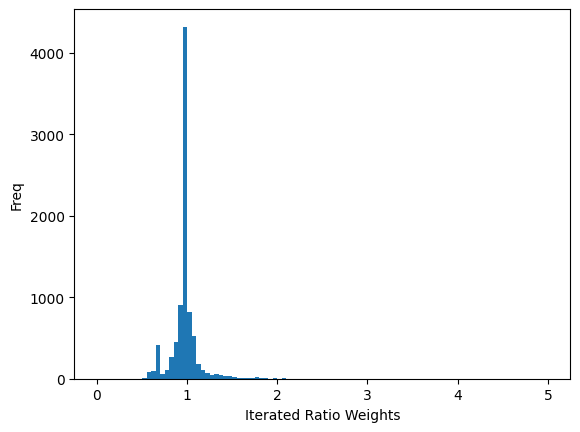

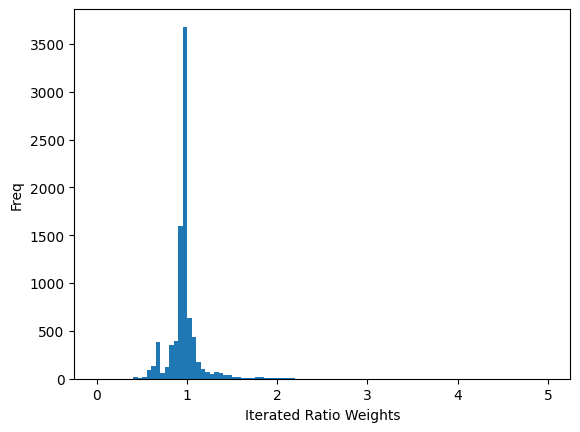

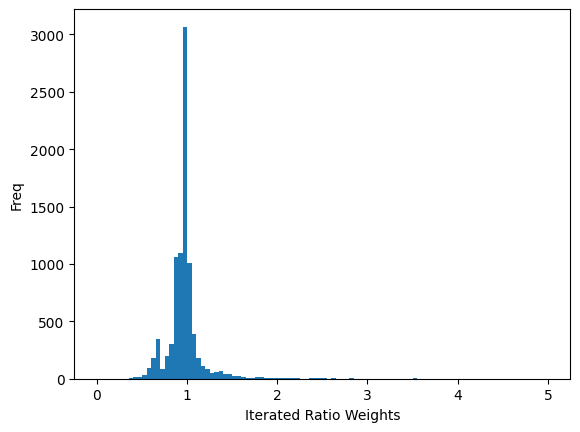

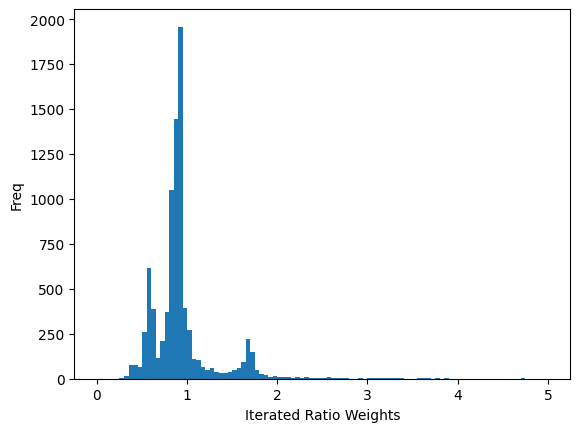

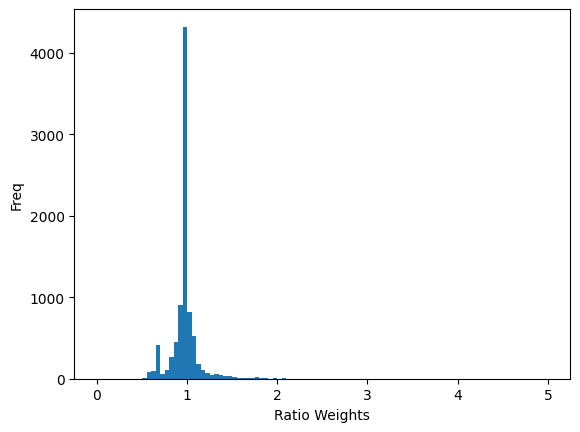

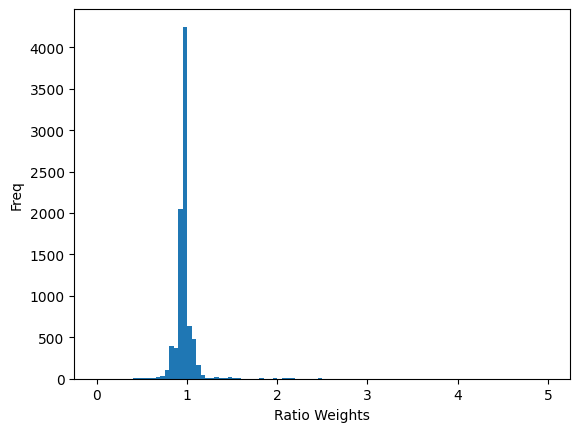

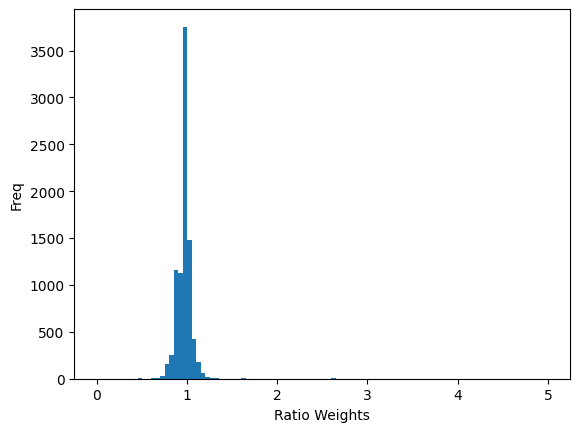

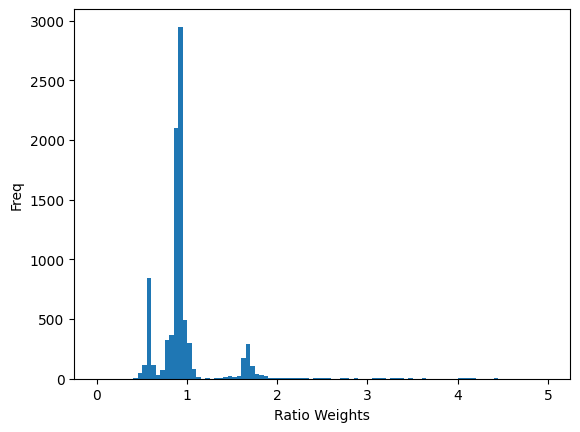

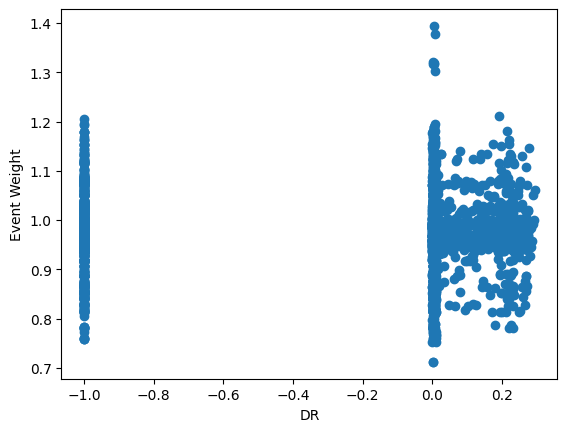

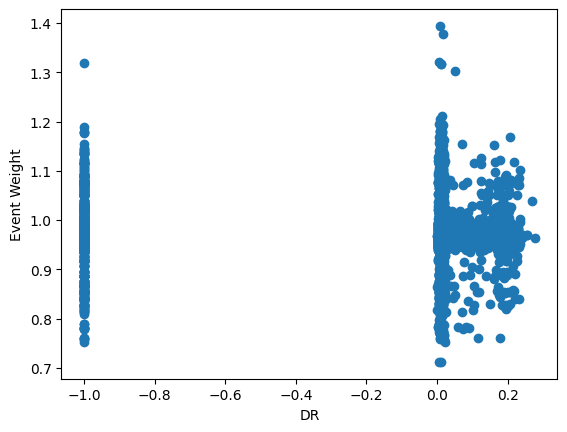

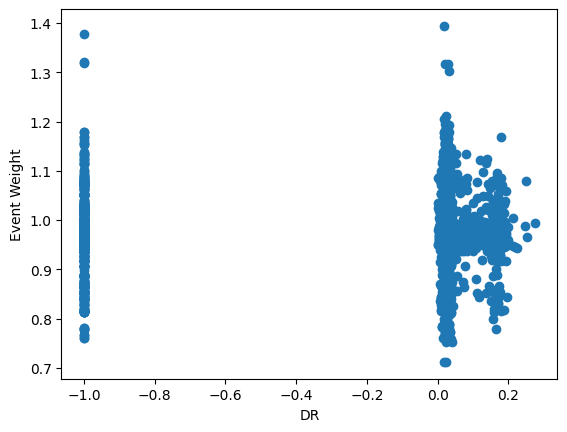

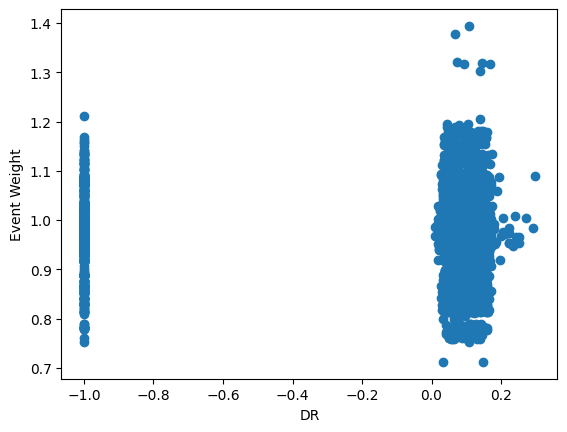

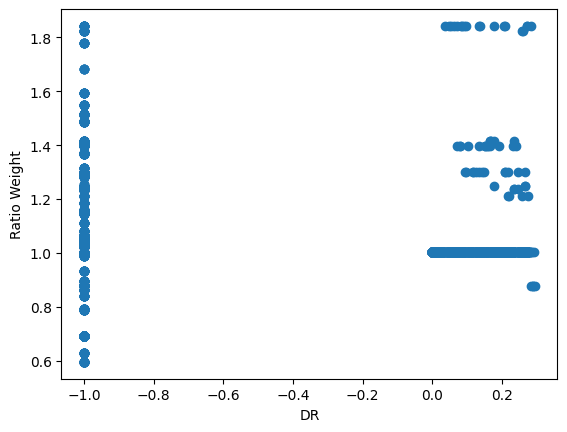

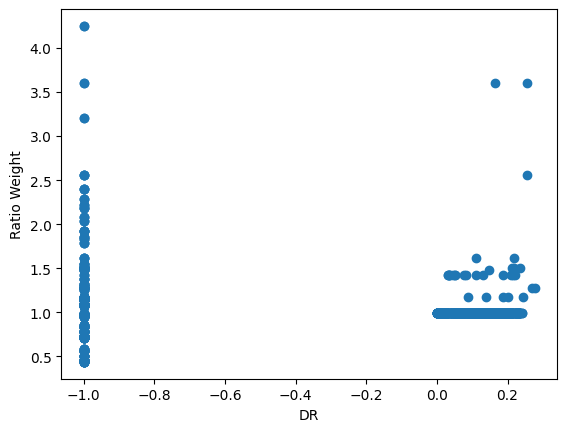

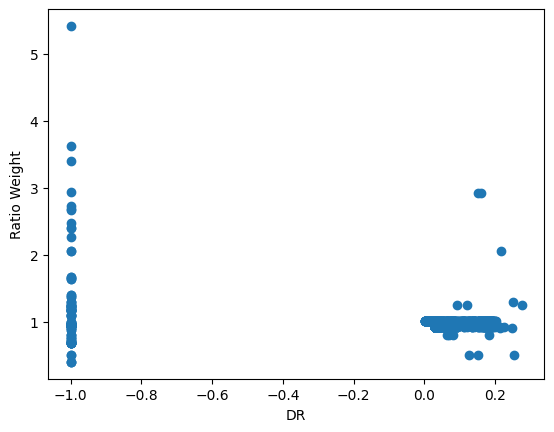

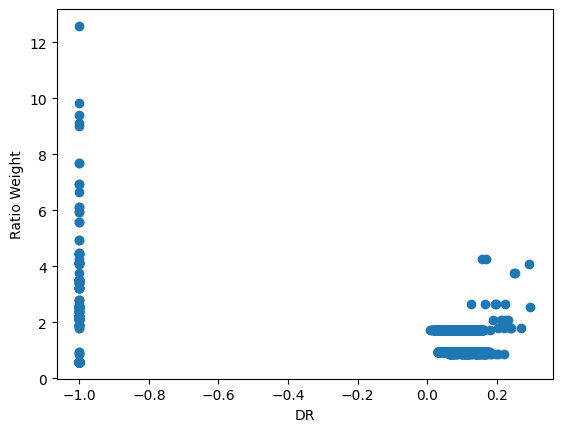

In [20]:
weights = MC.EventWeight
for i in range(4):
    weights = weights*mcEvents['Ratio_Iter_'+str(i)].to_list()
    plt.hist(weights, bins=100, range=(0, 5), density=None)
    plt.xlabel('Iterated Ratio Weights')
    plt.ylabel('Freq')
    plt.show()

for i in range(4):
    weights = MC.EventWeight*mcEvents['Ratio_Station_'+str(i)].to_list()
    plt.hist(weights, bins=100, range=(0, 5), density=None)
    plt.xlabel('Ratio Weights')
    plt.ylabel('Freq')
    plt.show()

for i in range(4):
    plt.scatter(mcEvents['dtDRbyStation_'+str(i)].to_list(), mcEvents['EventWeight'].to_list())
    plt.xlabel('DR')
    plt.ylabel('Event Weight')
    plt.show()

for i in range(4):
    plt.scatter(mcEvents['dtDRbyStation_'+str(i)].to_list(), mcEvents['Ratio_Station_'+str(i)].to_list())
    plt.xlabel('DR')
    plt.ylabel('Ratio Weight')
    plt.show()